1. 载入样本

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from scipy import stats
import pandas as pd
titanic_data = pd.read_csv("data/titanic3.csv")
print(titanic_data.columns)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


2. 处理样本中的离散数据和Nan值

In [40]:
titanic_data = pd.concat([titanic_data,
    pd.get_dummies(titanic_data['sex']),
    pd.get_dummies(titanic_data['embarked'], prefix="embark"),
    pd.get_dummies(titanic_data['pclass'], prefix="class")], axis=1
)
print(titanic_data.columns)
print(titanic_data['sex'])
print(titanic_data['female'])

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest', 'female',
       'male', 'embark_C', 'embark_Q', 'embark_S', 'class_1', 'class_2',
       'class_3'],
      dtype='object')
0       female
1         male
2       female
3         male
4       female
         ...  
1304    female
1305    female
1306      male
1307      male
1308      male
Name: sex, Length: 1309, dtype: object
0       1
1       0
2       1
3       0
4       1
       ..
1304    1
1305    1
1306    0
1307    0
1308    0
Name: female, Length: 1309, dtype: uint8


3. 对Nan值进行过滤填充

In [41]:
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())

4. 剔除无用的数据列

In [42]:
titanic_data = titanic_data.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest', 
'sex', 'embarked', 'pclass'], axis=1)
print(titanic_data.columns)

Index(['survived', 'age', 'sibsp', 'parch', 'fare', 'female', 'male',
       'embark_C', 'embark_Q', 'embark_S', 'class_1', 'class_2', 'class_3'],
      dtype='object')


5. 分离样本和标签制成数据集

In [43]:
labels = titanic_data["survived"].to_numpy()

titanic_data = titanic_data.drop(['survived'], axis=1)
data = titanic_data.to_numpy()

# 样本的属性名称
feature_names = list(titanic_data.columns)

# 将样本分成训练集和测试集两部分
np.random.seed(10) # 设置种子，保证每次运行所分的样本一致
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]
len(test_labels)

393

6. 定义Mish激活函数与多层全连接网络

In [44]:
class Mish(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    def forward(self, x):
        x = x*(torch.tanh(F.softplus(x)))
        return x
torch.manual_seed(0)
class ThreelinearModule(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.mish1 = Mish()
        self.linear2 = nn.Linear(12, 8)
        self.mish2 = Mish()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        lin1_out = self.linear1(x)
        out1 = self.mish1(lin1_out)
        out2 = self.mish2(self.linear2(out1))
        return self.softmax(self.linear3(out2))
    def getloss(self, x, y):
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y)
        return loss

7. 训练模型并输出结果

Epoch 1/200 => Loss: 0.72
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.52
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.49
Epoch 181/200 => Loss: 0.48
Train Accuracy: 0.8286026200873362
Test Accuracy: 0.7989821882951654


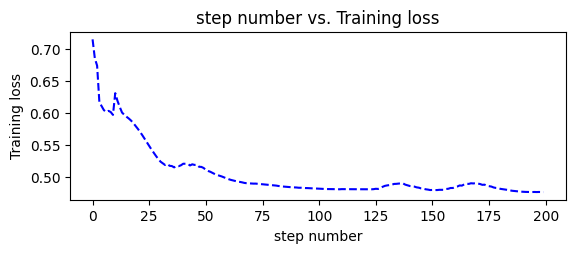

In [45]:
net = ThreelinearModule() # 实例化模型对象
num_epochs = 200 # 设置训练次数
optimizer = torch.optim.Adam(net.parameters(), lr=0.04) # 定义优化器

# 将输出的样本标签转为张量
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
labels_tensor = torch.from_numpy(train_labels)
losses = []         # 定义列表，用于接收每一步的损失值
for epoch in range(num_epochs):
    loss = net.getloss(input_tensor, labels_tensor)
    losses.append(loss.item())
    optimizer.zero_grad()   # 清空之前的梯度
    loss.backward()  # 反向传播损失值
    optimizer.step() # 更新参数
    if epoch%20 == 0:
        print('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

os.makedirs('models', exist_ok=True) # 新建文件夹
torch.save(net.state_dict(), 'models/titanic_model.pt') #保存模型
from code_02_moons_fun import plot_loss
plot_loss(losses) # 显示可视化结果

# 输出训练结果
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

# 测试模型
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))